In [175]:
import struct
import numpy as np
import cv2
from matplotlib import pyplot as plt
!git clone https://github.com/amir-saniyan/HodaDatasetReader
!pip install sh
from sh import cd
cd('HodaDatasetReader')
!ls

Cloning into 'HodaDatasetReader'...
remote: Enumerating objects: 24, done.
remote: Total 24 (delta 0), reused 0 (delta 0), pack-reused 24
Unpacking objects: 100% (24/24), done.
dataset_PRL.pdf		   Figure_1.png		 main.py
DigitDB			   Figure_2.png		 README.md
Farsi_Digits_Sample_1.gif  HodaDatasetReader.py
Farsi_Digits_Sample_2.gif  LICENSE


In [0]:

def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result

def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image

def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels


def read_hoda_dataset(dataset_path, images_height=32, images_width=32, one_hot=False, reshape=True):
    images, labels = read_hoda_cdb(dataset_path)
    assert len(images) == len(labels)

    X = np.zeros(shape=[len(images), images_height, images_width], dtype=np.float32)
    Y = np.zeros(shape=[len(labels)], dtype=np.int)

    for i in range(len(images)):
        image = images[i]
        # Image resizing.
        image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
        # Image normalization.
        image = image / 255
        # Image binarization.
        image = np.where(image >= 0.5, 1, 0)
        # Image.
        X[i] = image
        # Label.
        Y[i] = labels[i]

    if one_hot:
        Y = __convert_to_one_hot(Y, 10).astype(dtype=np.float32)
    else:
        Y = Y.astype(dtype=np.float32)

    if reshape:
        X = X.reshape(-1, images_height * images_width)
    else:
        X = X.reshape(-1, images_height, images_width, 1)

    return X, Y

Reading train dataset (Train 60000.cdb)...


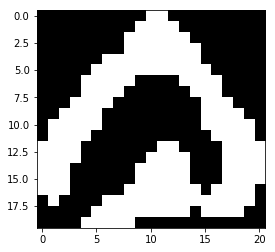

In [177]:
print('Reading train dataset (Train 60000.cdb)...')
X_train, Y_train = read_hoda_dataset(dataset_path='./DigitDB/Train 60000.cdb',images_height=32,images_width=32,one_hot=True,reshape=True)
train_images, train_labels = read_hoda_cdb('./DigitDB/Train 60000.cdb')
plt.imshow(train_images[1], cmap='gray')

Reading test dataset (Test 20000.cdb)...


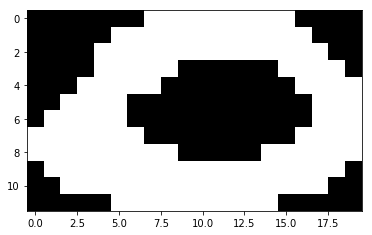

In [178]:
print('Reading test dataset (Test 20000.cdb)...')
X_test, Y_test = read_hoda_dataset(dataset_path='./DigitDB/Test 20000.cdb',images_height=32,images_width=32,one_hot=True,reshape=True)
test_images, test_labels = read_hoda_cdb('./DigitDB/Test 20000.cdb')
plt.imshow(test_images[1], cmap='gray')


In [0]:
from keras.models import Sequential
from keras.layers import Dense , Dropout


model = Sequential()

model.add(Dense(units=100, activation='relu', input_dim=32*32))
model.add(Dropout(0.01, noise_shape=None, seed=None))
model.add(Dense(units=500, activation='relu'))
model.add(Dense(units=10, activation='softmax'))


model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])


In [204]:
history = model.fit(X_train, Y_train, epochs=5, batch_size=32,validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 6s 113us/step - loss: 0.1298 - acc: 0.9631 - val_loss: 0.0803 - val_acc: 0.9800
Epoch 2/5
54000/54000 [==============================] - 5s 98us/step - loss: 0.0634 - acc: 0.9845 - val_loss: 0.0777 - val_acc: 0.9845
Epoch 3/5
54000/54000 [==============================] - 5s 98us/step - loss: 0.0478 - acc: 0.9881 - val_loss: 0.0784 - val_acc: 0.9862
Epoch 4/5
54000/54000 [==============================] - 5s 98us/step - loss: 0.0359 - acc: 0.9917 - val_loss: 0.1126 - val_acc: 0.9775
Epoch 5/5
54000/54000 [==============================] - 5s 98us/step - loss: 0.0304 - acc: 0.9934 - val_loss: 0.0982 - val_acc: 0.9868


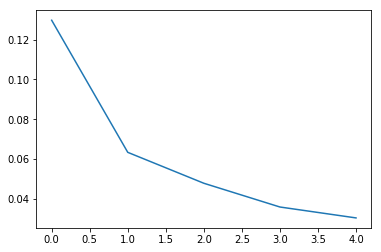

In [205]:
plt.plot(history.history['loss'])

In [206]:
score = model.evaluate(X_test,Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

20000/20000 [==============================] - 1s 42us/step
Test score: 0.16965275416950396
Test accuracy: 0.97315
